# GANs

Generative Adversarial Networks(GAN in short) is an advancement in the field of Machine Learning which is capable of generating new data samples including Text, Audio, Images, Videos, etc. using previously available data. GANs consist of two Artificial Neural Networks or Convolution Neural Networks models namely Generator and Discriminator which are trained against each other (and thus Adversarial). We’ll discuss more this in the following section.

## How does GAN Work?


GANs consists of two ANN or CNN models:

  1- Generator Model: Used to generate new images which look like real images.
  
  2- Discriminator Model: Used to classify images as real or fake.
Let us understand each separately.



**The Generator Model**

The Generator Model generates new images by taking a fixed size random noise as an input. Generated images are then fed to the Discriminator Model.

The main goal of the Generator is to fool the Discriminator by generating images that look like real images and thus makes it harder for the Discriminator to classify images as real or fake.

**The Discriminator Model**

The Discriminator Model takes an image as an input (generated and real) and classifies it as real or fake.

Generated images come from the Generator and the real images come from the training data.

The discriminator model is the simple binary classification model.

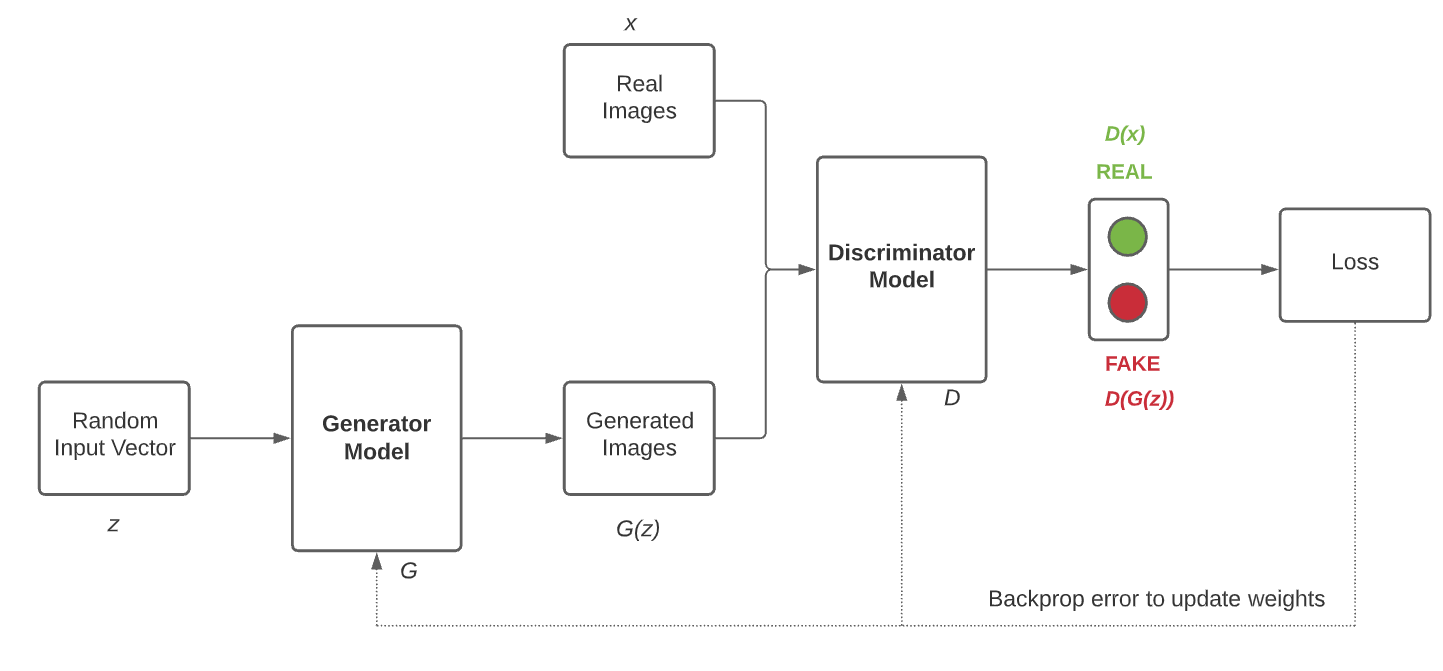

The Generator Model G takes a random input vector z as an input and generates the images G(z). These generated images along with the real images x from training data are then fed to the Discriminator Model D. The Discriminator Model then classifies the images as real or fake. Then,  we have to measure the loss and this loss has to be back propagated to update the weights of  the Generator and the Discriminator.

When we are training the Discriminator, we have to freeze the Generator and back propagate errors to only update the Discriminator.

When we are training the Generator, we have to freeze the Discriminator and back propagate errors to only update the Generator.

Thus the Generator Model and the Discriminator Model getting better and better at each epoch.

We have to stop training when it attains the Nash Equilibrium or D(x) = 0.5 for all x. In simple words, when the generated images look almost like real images. 

Let us introduce some notations to understand the loss function of the GANs.

G	Generator Model

D	Discriminator Model

z	Random Noise (Fixed size input vector)

x	Real Image

G(z)	Image generated by Generator (Fake Image)

pdata(x)	Probability Distribution of Real Images

pz(z)	Probability Distribution of Fake Images

D(G(z))	Discriminator’s output when the generated image is an input

D(x)	Discriminator’s output when the real image is an input

The fight between the Generator Model and the Discriminator Model can be expressed mathematically as:

loss function

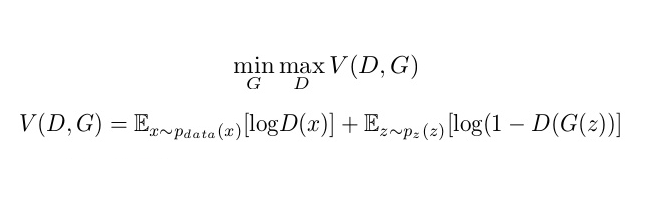

Note: The term Ex~pdata(x) [log D(x)] can be read as E of log(D(x)) when x is sampled from pdata(x) and similar for the second term.

As we can see in the equation, the Generator wants to minimize the V(D, G) whereas the  Discriminator wants to maximize the V(D, G). Let us understand both terms:

  1- Ex~pdata(x) [log D(x)]: Average log probability of D when real image is input.

  2- Ez~pz(z) [log(1 – D(G(z)))]: Average log probability of D when the generated image is input.
Let us understand the equation by thinking from the Generator’s and the Discriminator’s perspectives separately.

**Discriminator’s perspective**

The Discriminator wants to maximize the loss function V(D, G) by correctly classifying real and fake images.

The first term suggests that the Discriminator wants to make D(x) as close to 1 as possible, i.e. correctly classifying real images as real.


The second term suggests that the Discriminator wants to make D(G(x)) as close to 0 as possible, i.e. correctly classifying fake images as fake and thus maximize the term eventually (1 – smaller number will result in a larger number). Note: Probability lies in the range of 0-1.

Thus, The Discriminator tries to maximize both the terms.

**Generator’s perspective**

The Generator wants to minimize the loss function V(D, G) by generating images that look like real images and tries to fool the Discriminator. 

The second term suggests that the Generator wants to make D(G(z)) as close to 1 (instead of 0) as possible and thus minimize the term eventually (1 – larger number will result in a smaller number). So that the Discriminator fails and misclassifies the images.

Thus, The Generator tries to minimize the second term.

## So, Now we’ve got a clear idea about the GANs. Let’s start implementing it using Tensorflow and Keras.

## Importing Libraries


In [ ]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from matplotlib import pyplot
import numpy as np
from math import sqrt

## Loading Datasets


In [ ]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1 # we are dividing each pixel value by 127.5 and subtracting it from 1 to have pixel values in the range of -1 to 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


## Some Necessary Functions

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    return x_input.reshape(n_samples, latent_dim)

In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

This function helps us to summarize the performance. This includes generating a fake sample, plotting it, and finally saving the model.

In [ ]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

The above function helps us to plot the results. We’ll use this to plot the generated images by the  Generator in later stages.

## Model 

#### Discriminator

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = define_discriminator()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Generator

In [ ]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

generator = define_generator(100)

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

gan_model = define_gan(generator, discriminator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Model Training

In [ ]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=10, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)       
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)              # Train the discriminator
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)    
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)              # Updates the discriminator’s weights
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)                # Updates the Generator's weights
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo) == 0:
            summarize_performance(i, g_model, latent_dim)

In [ ]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=5, n_batch=128)

## Generating Samples Using GAN

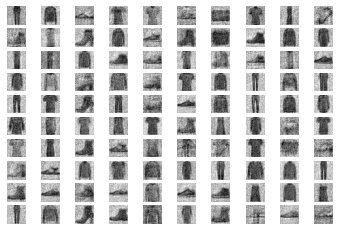

In [ ]:
model = load_model('model_9370.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)